#### Task1: Load Task2C_labeled.csv, Task2C_unlabeled.csv and Task2C_test.csv data sets and required libraries (e.g., H2O).

In [43]:
#Loading Libraries
set.seed(111)
options(warn=-1)
library(h2o)
library(ggplot2)

#Initialise H2o

localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '1G', startH2O = TRUE,ip="localhost")


 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         16 hours 26 minutes 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    2 months and 20 days  
    H2O cluster name:           H2O_started_from_R_rohan_dye013 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.53 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.6.0 (2019-04-26) 



In [44]:
#Loading the data

##########################
# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.frame <- h2o.importFile(path = './Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = './Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = './Task2C_test.csv' ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [45]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}


# autoencoder funtion

auto_encoder <- function(train.frame, units)
{
  NN.model <- h2o.deeplearning(    
  x = 1:ncol(train.frame), # select all pixels
  training_frame = train.frame, # specify the frame (imported file)    
  hidden = units, # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = TRUE, # is it an autoencoder? Yes!
  l2 = 0.1     
)
return(NN.model)
}

# classifier funtion

classifier_nn <- function(labeled.frame, units)
{
  NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), #  select all pixels + extra features
  y = 1,
  training_frame = labeled.frame, # specify the frame (imported file)    
  hidden = units, # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)
return(NN.model)
}

#### Task2:Train an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, .., 500

#### Task3: For each model in Step II, calculate and record the reconstruction error. Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error.Explain your findings

#### Task5: Build augmented self-taught networks using the models learnt in Step II. For each model:
   * **A. Add the output of the middle layer as extra features to the original feature set.**
   * **B. Train a 3-layer NN (similar to Step 4) using all features (original + extra).Then calculate and record the test error.**

In [46]:
K=seq(20, 500, 20)  #Iterate on K in intervals of 20

#Initialise dataframe to record reconstruction and classification errors
reconstruction.error <- data.frame(k=rep(K, each=1),reconstruction_test_error=rep(0, length(K)))
classification.error <- data.frame(k=rep(K, each=1),classification_test_error=rep(0, length(K)))

for (k in K){
    
    # Building an Autoencoder
    encoder_output = auto_encoder(train.frame, k)
    
    # Calculating the error on Autoencoder outputs
    error <- h2o.anomaly(encoder_output, train.frame)
    
    # Record the mean error to the dataframe
    reconstruction.error[reconstruction.error$k==k, c('reconstruction_test_error')] <- mean(error)
    
    # Generating the extra features from the autoencoder
    extraFeatures = h2o.deepfeatures(encoder_output, labeled.frame[,-1], layer=1)
    
    # Concatenating the added features to the original inputs
    all_features <- h2o.cbind(labeled.frame, extraFeatures)
    
    # Training the 3-layer NN classifier using all features (original + extra)
    classifier = classifier_nn(all_features, 100)
    
    # calculating the prediction using classifier model on test data
    prediction <- h2o.predict(classifier,test.frame)
    
    # calculating and recording the classification error
    cls_error <- error.rate(prediction[,1], test.frame[,1])
    classification.error[classification.error$k==k, c('classification_test_error')] <- cls_error
    
    
    #Removing the unwanted variables generated in the loop
    rm(encoder_output,error,extraFeatures,all_features,classifier,prediction)
    
}


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

####  Plot of Reconstruction Error vs. Hidden Layer and explaination of the findings (Task 3)

* We get a the minimum error of 0.003673218 at k=480 
* It can be seen from the below plot that the reconstruction error follows the general trend,i.e it decreases with increase in the number of neurons in the middle layer.

In [47]:
 reconstruction.error #Record of Reconstruction Error   

k,reconstruction_test_error
<dbl>,<dbl>
20,0.011347880
40,0.007013837
60,0.005643241
80,0.005265462
100,0.004618410
120,0.004887337
140,0.004513605
160,0.004661023
180,0.004389012


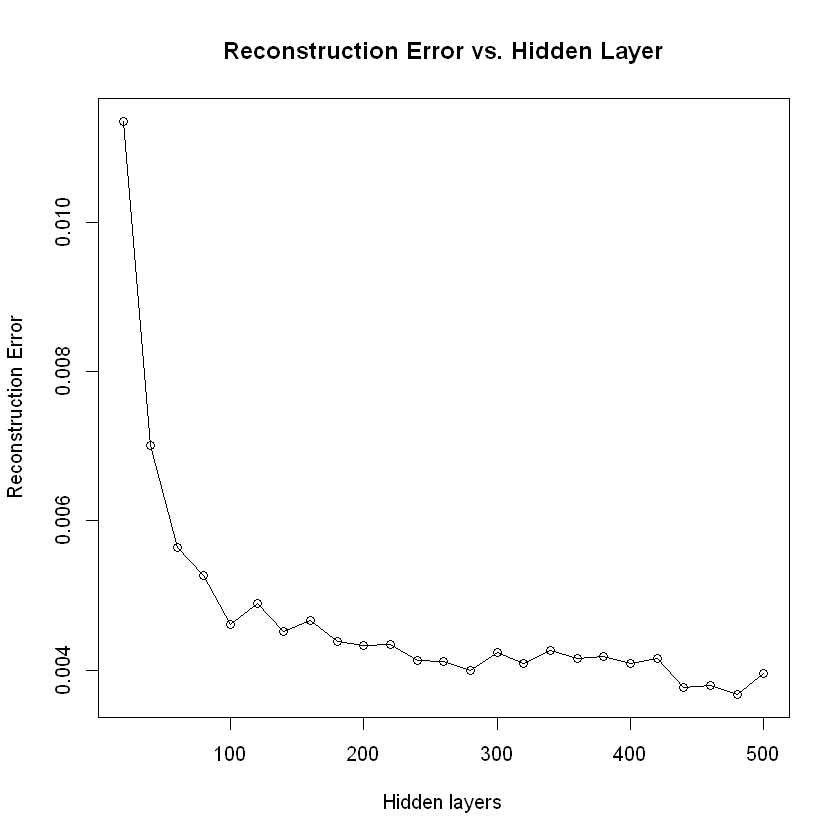

In [48]:
# Ploting reconstruction error
plot(reconstruction.error,type='o',ylab='Reconstruction Error',xlab='Hidden layers',main='Reconstruction Error vs. Hidden Layer')

#### Task4. Use the 3-layer NN from Activity 5.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) to build a classification model with 100 units in the hidden layer using all the original attributes from the training set. Then, calculate and record the test error.

In [49]:
#buliding the classifier model on training data
label.pred <- h2o.predict(classifier_nn(labeled.frame,100), labeled.frame)$predict

# calculating error on training data
train.error = error.rate(labeled.frame$label, label.pred)

#Building model on test data
test.predict <- h2o.predict(classifier_nn(labeled.frame,100), test.frame)$predict

#calculating error rate on test dataset
test.error = error.rate(test.frame$label, test.predict)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [50]:
test.error  #Displaying the test error

[1] 0.506

####  Task6. Record classification Error and Plot Number of Extra fratures v.s  Reconstruction Error 

In [51]:
classification.error #Record of classification error

k,classification_test_error
<dbl>,<dbl>
20,0.541
40,0.342
60,0.563
80,0.637
100,0.635
120,0.553
140,0.593
160,0.565
180,0.585


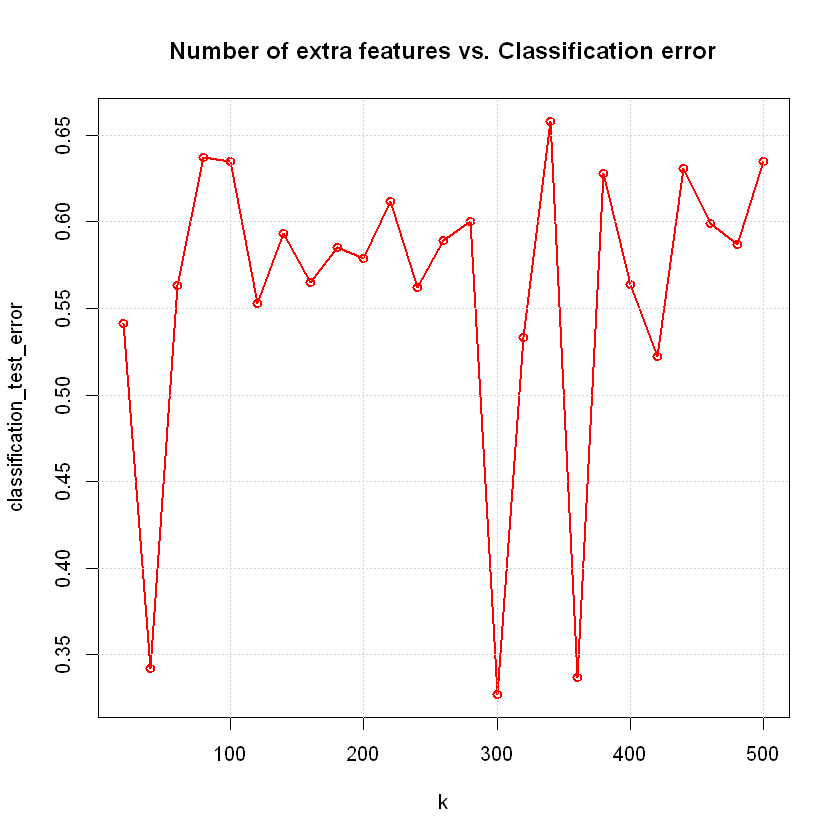

In [52]:
plot(classification.error,type='o',col = "red",lwd = 2, main='Number of extra features vs. Classification error')
grid()

#### Task7. Report the optimum number(s) of units in the middle layer of the autoencoder in terms of the reconstruction and misclassification errors.

* **Optimum number of units in the middle layer in terms of reconstruction eror**

In [53]:
reconstruction.error[reconstruction.error[,2]==min(reconstruction.error[,2]),]

,k,reconstruction_test_error
,<dbl>,<dbl>
24,480,0.003673218


* **Optimum number of units in the middle layer in terms of classification eror**

In [54]:
classification.error[classification.error[,2]==min(classification.error[,2]),]

,k,classification_test_error
,<dbl>,<dbl>
15,300,0.327


#### Task 8. Comparing the plot from Step III and VI, do you observe any relation between the reconstruction error and misclassification error?

* We get a minimum reconstruction error of 0.003673218 for 480 neurons in task3, while in task 6 we get a minimum classification error of 0.327 for 300 extra featues.


* The plot in task 3 suggests that generally the reconstruction error decreases with the increase in number of neurons in the middle layer.


* But the plot in task6, i.e classification error v.s the extra features, shows no such general behaviour. There are erratic fluctuations in the classification error with respect to the increase in number of extra features and the classification test error is much higher than the reconstruction error.


* The main reason for this could be that adding extra features makes the model very complex and hence it leads to overfitting. Therefore the overfitting results in high test error.


* One of the ways to improve this could be to increase the number of neurons of the classifier while we add extra features to it, rather than fixing it to 100.


* In the autoencoder we are continuously increasing the number of neurons and hence diminishing the error whereas in the classifier we have fixed the neurons to 100 and we keep on increasing the complexity (features), which leads to poor test results.